# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [51]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define a function to load data and aggregate them
def load_and_aggregate_data(file_paths):
    # Read the first CSV file to initialize the combined DataFrame
    first_file_path = file_paths[0]
    stock_name = first_file_path.split('/')[-1].split('_')[0]
    combined_df = pd.read_csv(first_file_path)
    combined_df = combined_df.rename(columns={'Open': f'Open{stock_name}',
                                              'High': f'High{stock_name}',
                                              'Low': f'Low{stock_name}',
                                              'Close': f'Close{stock_name}',
                                              'Volume': f'Volume{stock_name}'})
    combined_df = combined_df.drop(columns=['Name'])

    # Join the remaining data frames
    for file_path in file_paths[1:]:
        stock_name = file_path.split('/')[-1].split('_')[0]
        df = pd.read_csv(file_path)
        df = df.rename(columns={'Open': f'Open{stock_name}',
                                'High': f'High{stock_name}',
                                'Low': f'Low{stock_name}',
                                'Close': f'Close{stock_name}',
                                'Volume': f'Volume{stock_name}'})
        df = df.drop(columns=['Name'])

        combined_df = pd.merge(combined_df, df, on='Date', how='inner')

    return combined_df

In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/RNN_Stocks_Data/AMZN_stocks_data.csv',
    '/content/drive/MyDrive/Colab Notebooks/RNN_Stocks_Data/GOOGL_stocks_data.csv',
    '/content/drive/MyDrive/Colab Notebooks/RNN_Stocks_Data/IBM_stocks_data.csv',
    '/content/drive/MyDrive/Colab Notebooks/RNN_Stocks_Data/MSFT_stocks_data.csv'
]

# Use the aggregation function to read the files and combine them
combined_stock_data = load_and_aggregate_data(file_paths)

In [5]:
# View specifics of the data
combined_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3019 non-null   object 
 1   OpenAMZN     3019 non-null   float64
 2   HighAMZN     3019 non-null   float64
 3   LowAMZN      3019 non-null   float64
 4   CloseAMZN    3019 non-null   float64
 5   VolumeAMZN   3019 non-null   int64  
 6   OpenGOOGL    3019 non-null   float64
 7   HighGOOGL    3019 non-null   float64
 8   LowGOOGL     3019 non-null   float64
 9   CloseGOOGL   3019 non-null   float64
 10  VolumeGOOGL  3019 non-null   int64  
 11  OpenIBM      3018 non-null   float64
 12  HighIBM      3019 non-null   float64
 13  LowIBM       3018 non-null   float64
 14  CloseIBM     3019 non-null   float64
 15  VolumeIBM    3019 non-null   int64  
 16  OpenMSFT     3019 non-null   float64
 17  HighMSFT     3019 non-null   float64
 18  LowMSFT      3019 non-null   float64
 19  CloseM

In [6]:
combined_stock_data.describe()

,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,VolumeGOOGL,OpenIBM,HighIBM,LowIBM,CloseIBM,VolumeIBM,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3018.000000,3019.000000,3018.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06,428.200802,431.835618,424.130275,428.044001,3.551504e+06,145.521034,146.687493,144.477203,145.623031,5.773563e+06,36.496817,36.827903,36.173190,36.513412,5.161762e+07
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06,236.320026,237.514087,234.923747,236.343238,3.038599e+06,37.559958,37.618348,37.482585,37.534272,3.193327e+06,14.683337,14.742483,14.620057,14.694656,3.114958e+07
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05,131.390000,134.820000,123.770000,128.850000,5.211410e+05,72.740000,73.940000,69.500000,71.740000,2.542560e+05,15.200000,15.620000,14.870000,15.150000,7.425603e+06
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06,247.775000,250.190000,244.035000,247.605000,1.760854e+06,116.402500,117.750000,115.480000,116.520000,3.622178e+06,26.785000,27.045000,26.535000,26.835000,3.136557e+07
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06,310.480000,312.810000,307.790000,310.080000,2.517630e+06,149.650000,150.410000,148.480000,149.330000,4.926500e+06,29.990000,30.230000,29.780000,30.000000,4.617529e+07
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06,572.140000,575.975000,565.900000,570.770000,4.242182e+06,178.452500,179.775000,177.340000,178.690000,6.966642e+06,44.545000,44.980000,44.090000,44.400000,6.322291e+07
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08,1083.020000,1086.490000,1072.270000,1085.090000,4.118289e+07,215.380000,215.900000,214.300000,215.800000,3.077428e+07,87.120000,87.500000,86.230000,86.850000,5.910786e+08


In [7]:
combined_stock_data.head(10)

,Date,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,...,OpenIBM,HighIBM,LowIBM,CloseIBM,VolumeIBM,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,211.47,218.05,209.32,217.83,...,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,222.17,224.70,220.09,222.84,...,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,223.22,226.00,220.97,225.85,...,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,228.66,235.49,226.85,233.06,...,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,233.44,236.94,230.70,233.68,...,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836
5,2006-01-10,46.41,46.75,45.36,45.65,9686957,232.44,235.36,231.25,235.11,...,83.15,84.12,83.12,84.07,5701000,26.65,27.02,26.59,27.00,64924946
6,2006-01-11,45.65,45.70,44.26,44.93,8497383,235.87,237.79,234.82,236.05,...,84.37,84.81,83.40,84.17,5776500,27.01,27.39,26.90,27.29,70123544
7,2006-01-12,44.79,45.09,44.09,44.36,5818301,237.10,237.73,230.98,232.05,...,83.82,83.96,83.40,83.57,4926500,27.25,27.26,26.97,27.14,45994725
8,2006-01-13,44.48,44.85,44.00,44.40,4432237,232.39,233.68,231.04,233.36,...,83.00,83.45,82.50,83.17,6921700,27.03,27.25,27.01,27.19,41449046
9,2006-01-17,43.95,44.32,43.66,44.00,5635225,231.76,235.18,231.50,233.79,...,82.80,83.16,82.54,83.00,8761700,26.90,27.19,26.90,26.99,58574807


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [8]:
# Handle Missing Values
combined_stock_data.isnull().sum()

,0
Date,0
OpenAMZN,0
HighAMZN,0
LowAMZN,0
CloseAMZN,0
VolumeAMZN,0
OpenGOOGL,0
HighGOOGL,0
LowGOOGL,0
CloseGOOGL,0


In [9]:
combined_stock_data = combined_stock_data.dropna()

In [10]:
print("Missing values after handling:")
combined_stock_data.isnull().sum()

Missing values after handling:


,0
Date,0
OpenAMZN,0
HighAMZN,0
LowAMZN,0
CloseAMZN,0
VolumeAMZN,0
OpenGOOGL,0
HighGOOGL,0
LowGOOGL,0
CloseGOOGL,0


In [11]:
combined_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3018 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3018 non-null   object 
 1   OpenAMZN     3018 non-null   float64
 2   HighAMZN     3018 non-null   float64
 3   LowAMZN      3018 non-null   float64
 4   CloseAMZN    3018 non-null   float64
 5   VolumeAMZN   3018 non-null   int64  
 6   OpenGOOGL    3018 non-null   float64
 7   HighGOOGL    3018 non-null   float64
 8   LowGOOGL     3018 non-null   float64
 9   CloseGOOGL   3018 non-null   float64
 10  VolumeGOOGL  3018 non-null   int64  
 11  OpenIBM      3018 non-null   float64
 12  HighIBM      3018 non-null   float64
 13  LowIBM       3018 non-null   float64
 14  CloseIBM     3018 non-null   float64
 15  VolumeIBM    3018 non-null   int64  
 16  OpenMSFT     3018 non-null   float64
 17  HighMSFT     3018 non-null   float64
 18  LowMSFT      3018 non-null   float64
 19  CloseMSFT  

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

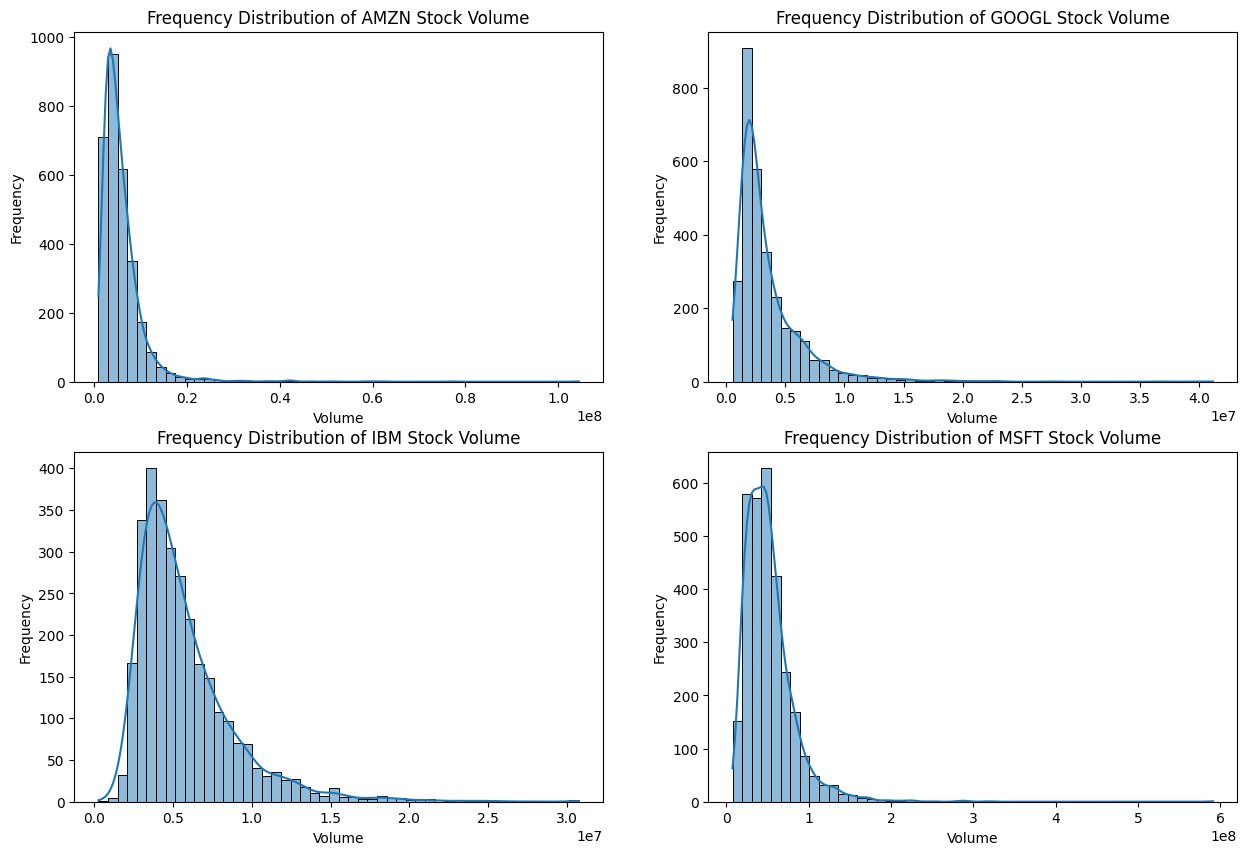

In [12]:
# Frequency distribution of volumes
# Plot histograms for each company's volume
companies = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
plt.figure(figsize=(15, 10))

for i, company in enumerate(companies):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=combined_stock_data, x=f'Volume{company}', bins=50, kde=True)
    plt.title(f'Frequency Distribution of {company} Stock Volume')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.show()

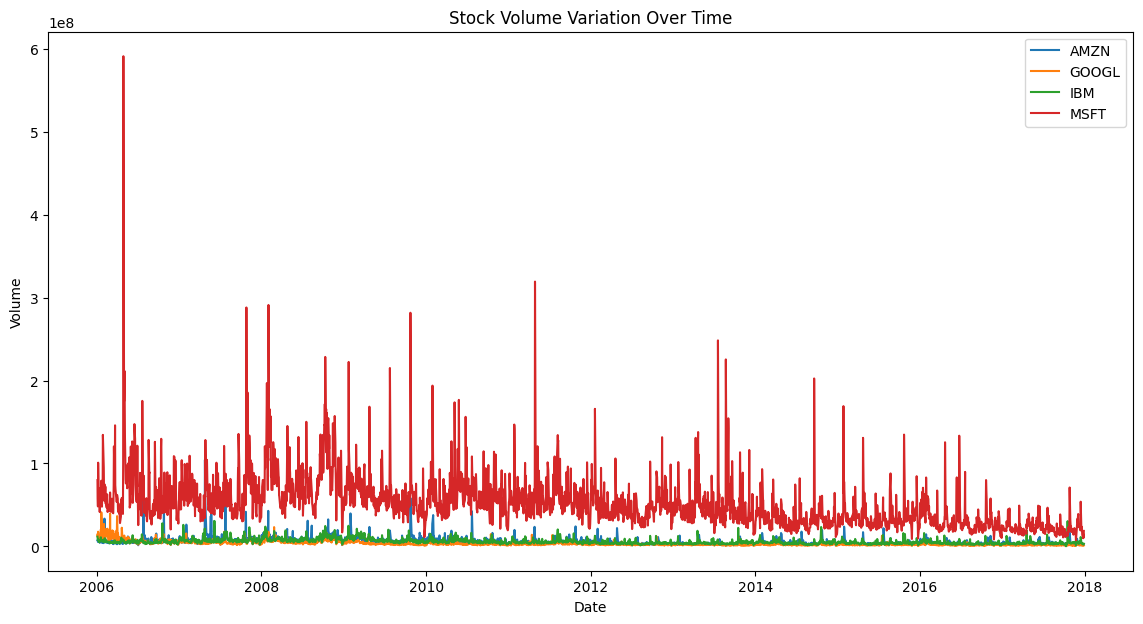

In [13]:
# Stock volume variation over time
# Convert 'Date' column to datetime objects
combined_stock_data['Date'] = pd.to_datetime(combined_stock_data['Date'])

# Plot volume over time for each company
plt.figure(figsize=(14, 7))

for company in companies:
    sns.lineplot(data=combined_stock_data, x='Date', y=f'Volume{company}', label=company)

plt.title('Stock Volume Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [14]:
# Analyse correlations
# Calculate the correlation matrix for all numerical columns
correlation_matrix = combined_stock_data.select_dtypes(include=np.number).corr()

In [15]:
# Correlation matrix
correlation_matrix

,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,VolumeGOOGL,OpenIBM,HighIBM,LowIBM,CloseIBM,VolumeIBM,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
OpenAMZN,1.000000,0.999931,0.999897,0.999834,-0.328318,0.972644,0.972504,0.972994,0.972735,-0.440793,0.396641,0.393732,0.397839,0.395173,-0.372165,0.953434,0.953345,0.953419,0.953446,-0.488958
HighAMZN,0.999931,1.000000,0.999889,0.999924,-0.326409,0.972767,0.972710,0.973154,0.972955,-0.440776,0.397116,0.394265,0.398315,0.395709,-0.371636,0.953299,0.953281,0.953304,0.953392,-0.488203
LowAMZN,0.999897,0.999889,1.000000,0.999930,-0.330015,0.972317,0.972215,0.972828,0.972567,-0.441497,0.396266,0.393356,0.397539,0.394865,-0.373330,0.953503,0.953436,0.953625,0.953644,-0.490040
CloseAMZN,0.999834,0.999924,0.999930,1.000000,-0.328009,0.972482,0.972442,0.972984,0.972817,-0.441292,0.396644,0.393798,0.397919,0.395349,-0.372818,0.953331,0.953326,0.953443,0.953563,-0.489236
VolumeAMZN,-0.328318,-0.326409,-0.330015,-0.328009,1.000000,-0.335282,-0.334037,-0.337847,-0.336239,0.327214,-0.389324,-0.386539,-0.392234,-0.389026,0.390736,-0.279138,-0.277289,-0.282671,-0.280460,0.384698
OpenGOOGL,0.972644,0.972767,0.972317,0.972482,-0.335282,1.000000,0.999894,0.999841,0.999743,-0.443231,0.411837,0.408774,0.413145,0.410178,-0.384548,0.968742,0.968778,0.968578,0.968750,-0.510437
HighGOOGL,0.972504,0.972710,0.972215,0.972442,-0.334037,0.999894,1.000000,0.999827,0.999866,-0.440786,0.410579,0.407616,0.411906,0.409028,-0.382638,0.968652,0.968803,0.968520,0.968788,-0.509071
LowGOOGL,0.972994,0.973154,0.972828,0.972984,-0.337847,0.999841,0.999827,1.000000,0.999896,-0.447852,0.413376,0.410321,0.414849,0.411868,-0.387848,0.968731,0.968789,0.968764,0.968928,-0.513416
CloseGOOGL,0.972735,0.972955,0.972567,0.972817,-0.336239,0.999743,0.999866,0.999896,1.000000,-0.444655,0.411987,0.409043,0.413462,0.410647,-0.385487,0.968578,0.968737,0.968606,0.968930,-0.511782
VolumeGOOGL,-0.440793,-0.440776,-0.441497,-0.441292,0.327214,-0.443231,-0.440786,-0.447852,-0.444655,1.000000,-0.546490,-0.544280,-0.549512,-0.546949,0.445371,-0.363245,-0.361593,-0.365737,-0.364325,0.441054


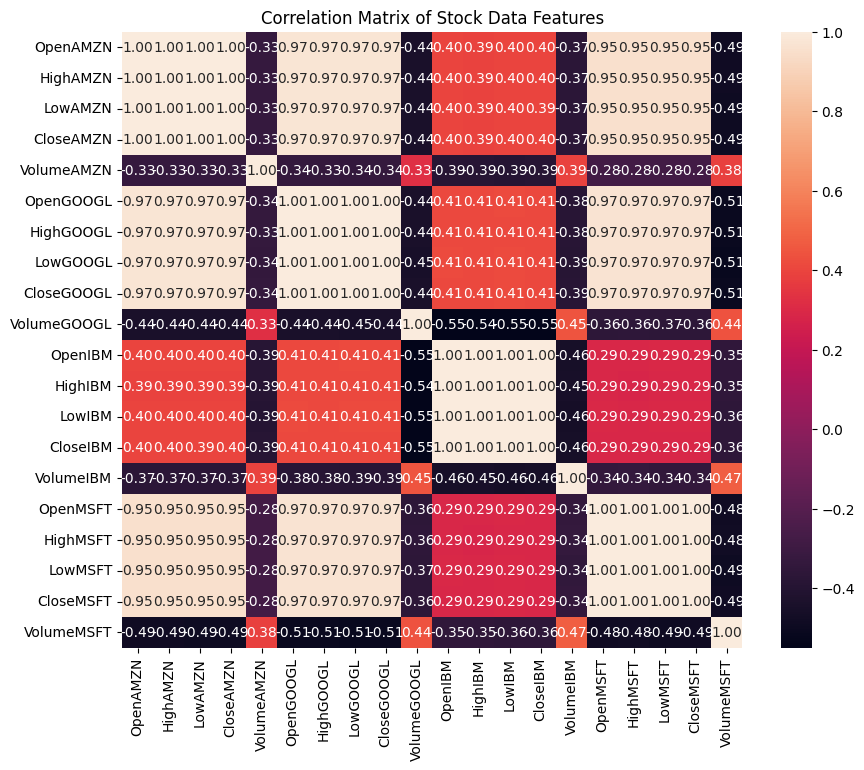

In [16]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Stock Data Features')
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [17]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windowed_data(df, window_size, stride):
    X = []
    y = []
    target_names = df.columns.tolist()
    # Iterate through the DataFrame to create windows
    for i in range(0, len(df) - window_size, stride):
        # Create the input window
        X_window = df.iloc[i : i + window_size].copy()

        # Create the target window (the row immediately following the input window)
        y_window = df.iloc[i + window_size : i + window_size + 1][target_names].copy()

        # Append the windows to the lists
        X.append(X_window)
        y.append(y_window)

    return X, y

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [18]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
def scale_windowed_data(X, y):
    X_scaled = []
    y_scaled = []
    scalers = []

    for x_window, y_window in zip(X, y):
        # Scale input window
        scaler = MinMaxScaler()
        x_window_scaled = scaler.fit_transform(x_window.select_dtypes(include=np.number)) # Scale only numerical columns
        X_scaled.append(x_window_scaled)

        # Scale target window
        y_window_scaled = scaler.transform(y_window.select_dtypes(include=np.number)) # Scale only numerical columns
        y_scaled.append(y_window_scaled)

        scalers.append(scaler)

    return X_scaled, y_scaled, scalers

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [19]:
# Define a function to create input and output data points from the master DataFrame
def prepare_rnn_data(df, target_name, window_size, stride, test_size):
    target_map = {'AMZN': 4, 'GOOGL': 9, 'IBM': 14, 'MSFT': 1}
    target_index = target_map[target_name]

    # Create windowed data
    X, y = create_windowed_data(df, window_size, stride)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False) # shuffle=False for time series data

    # Scale the training and testing data separately
    X_train_scaled, y_train_scaled, scalers_train = scale_windowed_data(X_train, y_train)
    X_test_scaled, y_test_scaled, scalers_test = scale_windowed_data(X_test, y_test)

    # Select desired company
    y_train_scaled_target = []
    for i in range(len(y_train_scaled)):
        y_train_scaled_target.append(y_train_scaled[i][:, target_index])

    y_test_scaled_target = []
    for i in range(len(y_test_scaled)):
        y_test_scaled_target.append(y_test_scaled[i][:, target_index])

    # Convert the lists of numpy arrays to single numpy arrays for RNN input
    X_train_scaled = np.array(X_train_scaled)
    X_test_scaled = np.array(X_test_scaled)
    y_train_scaled = np.array(y_train_scaled_target)
    y_test_scaled = np.array(y_test_scaled_target)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [20]:
# Checking for patterns in different sequence lengths

# Convert 'Date' column to datetime objects if not already
combined_stock_data['Date'] = pd.to_datetime(combined_stock_data['Date'])

# Create 'Month' and 'Quarter' columns for grouping
combined_stock_data['Month'] = combined_stock_data['Date'].dt.to_period('M')
combined_stock_data['Quarter'] = combined_stock_data['Date'].dt.to_period('Q')

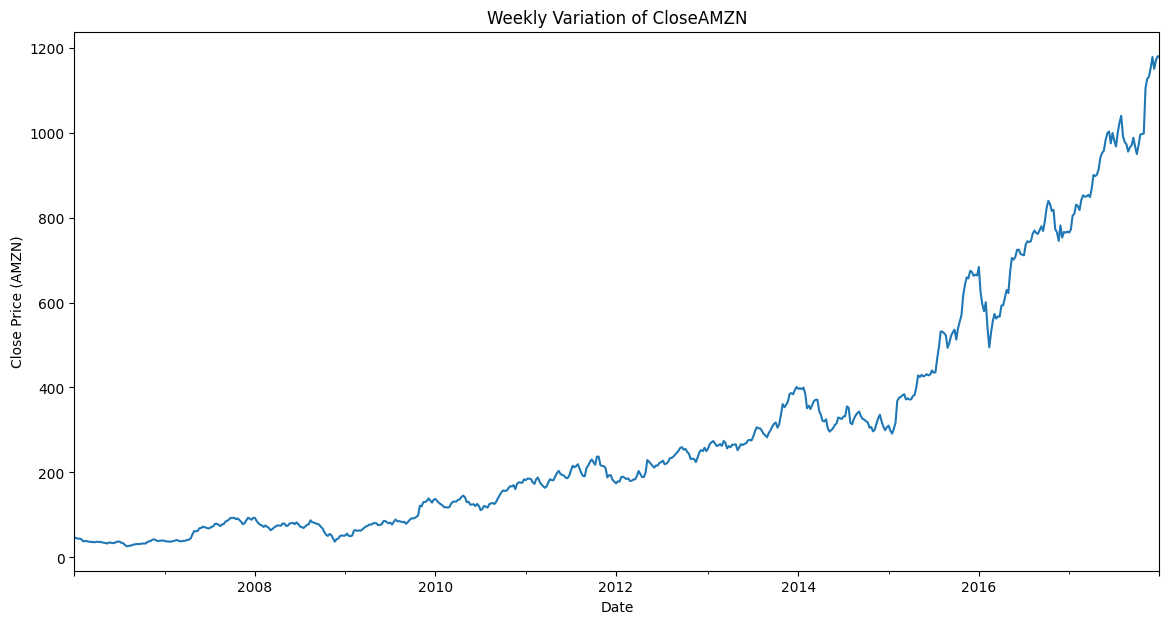

In [21]:
# Weekly variation
plt.figure(figsize=(14, 7))
combined_stock_data.set_index('Date')['CloseAMZN'].resample('W').mean().plot()
plt.title('Weekly Variation of CloseAMZN')
plt.xlabel('Date')
plt.ylabel('Close Price (AMZN)')
plt.show()

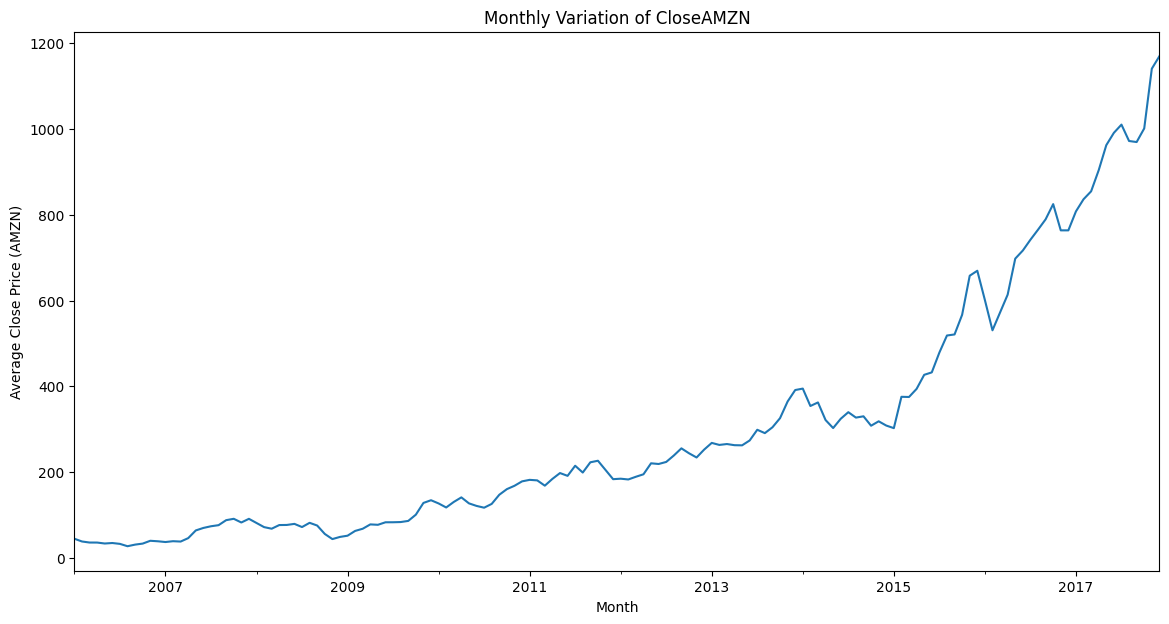

In [22]:
# Monthly variation
plt.figure(figsize=(14, 7))
combined_stock_data.groupby('Month')['CloseAMZN'].mean().plot()
plt.title('Monthly Variation of CloseAMZN')
plt.xlabel('Month')
plt.ylabel('Average Close Price (AMZN)')
plt.show()

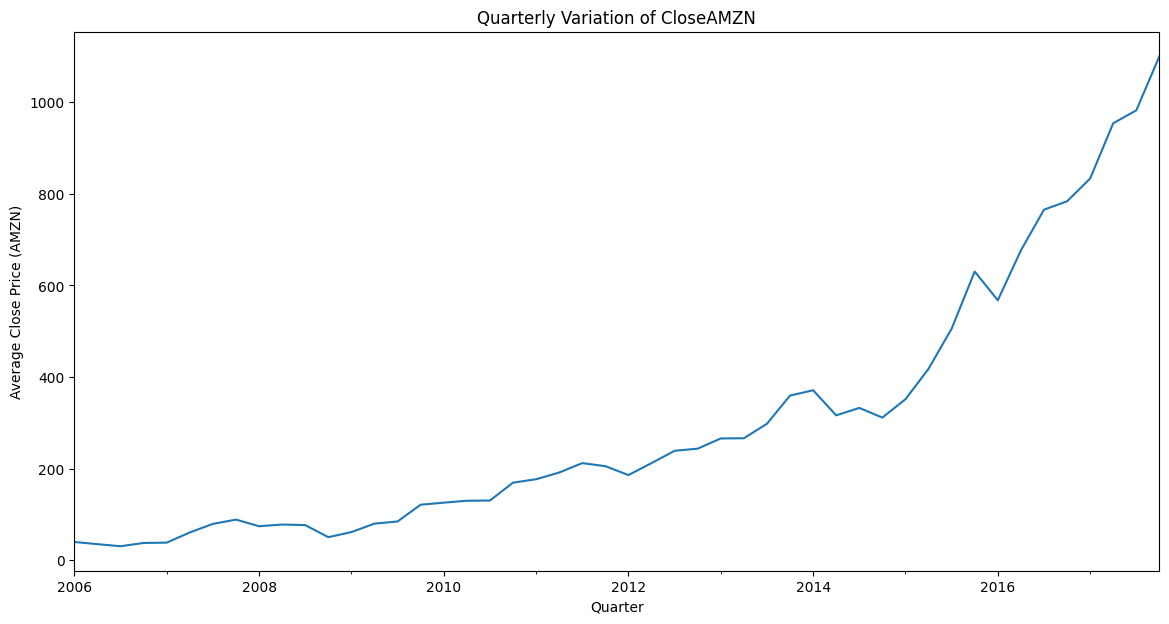

In [23]:
# Quarterly variation
plt.figure(figsize=(14, 7))
combined_stock_data.groupby('Quarter')['CloseAMZN'].mean().plot()
plt.title('Quarterly Variation of CloseAMZN')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price (AMZN)')
plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [24]:
# Create data instances from the master data frame using decided window size and window stride
window_size = 5
stride = 1
test_size = 0.3
target_name = 'AMZN' # We will predict the closing price for AMZN for now

X_train, X_test, y_train, y_test = prepare_rnn_data(
    combined_stock_data, target_name, window_size, stride, test_size
)

In [25]:
# Check the number of data points generated
print(f"Number of training samples (X_train): {len(X_train)}")
print(f"Number of testing samples (X_test): {len(X_test)}")
print(f"Number of training target samples (y_train): {len(y_train)}")
print(f"Number of testing target samples (y_test): {len(y_test)}")

Number of training samples (X_train): 2109
Number of testing samples (X_test): 904
Number of training target samples (y_train): 2109
Number of testing target samples (y_test): 904


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [26]:
# Check if the datasets are compatible inputs to neural networks
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nData type of X_train:", X_train.dtype)
print("Data type of X_test:", X_test.dtype)
print("Data type of y_train:", y_train.dtype)
print("Data type of y_test:", y_test.dtype)

# RNNs typically expect input in the shape (samples, time steps, features)
# Our current shapes are (samples, time steps, features) for X and (samples, 1, targets) for y
# This is a suitable format for many RNN architectures.
# The data types are also float64, which is appropriate for numerical input to neural networks.

Shape of X_train: (2109, 5, 20)
Shape of X_test: (904, 5, 20)
Shape of y_train: (2109, 1)
Shape of y_test: (904, 1)

Data type of X_train: float64
Data type of X_test: float64
Data type of y_train: float64
Data type of y_test: float64


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [27]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def build_simple_rnn_model(input_shape, units=50, activation='relu', num_layers=1):
    model = Sequential()
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Return sequences for all but the last RNN layer
        if i == 0:
            model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape, return_sequences=return_sequences))
        else:
            model.add(SimpleRNN(units=units, activation=activation, return_sequences=return_sequences))
    model.add(Dense(1)) # Output layer for predicting a single value (closing price)
    model.compile(optimizer='adam', loss='mse')
    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [28]:
# Find an optimal configuration of simple RNN



In [29]:
# Define the grid of hyperparameters to search
param_grid = {
    'units': [30, 50, 70],
    'epochs': [25, 50],
    'batch_size': [32, 64],
    'num_layers': [1, 2]
}

best_score = float('inf')
best_params = {}
best_model = None

# Iterate through the hyperparameter grid
for units in param_grid['units']:
    for epochs in param_grid['epochs']:
        for batch_size in param_grid['batch_size']:
            for num_layers in param_grid['num_layers']:
                print(f"Training with units={units}, epochs={epochs}, batch_size={batch_size}, num_layers={num_layers}")

                # Build the model
                model = build_simple_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                               units=units, activation='relu', num_layers=num_layers)

                # Train the model
                history = model.fit(
                    X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.3,  # Use a validation split during training
                    verbose=0  # Set verbose to 0 to reduce output during tuning
                )

                # Evaluate the model on the validation set
                loss = model.evaluate(X_test, y_test, verbose=0)
                mse = loss # For a single output and 'mse' loss, loss is the MSE

                print(f"  Validation MSE: {mse:.4f}")

                # Check if this is the best model so far
                if mse < best_score:
                    best_score = mse
                    best_params = {'units': units, 'epochs': epochs, 'batch_size': batch_size, 'num_layers': num_layers}
                    best_model = model # Store the best model


# Summarize results
print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Validation MSE: {best_score:.4f}")

Training with units=30, epochs=25, batch_size=32, num_layers=1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Validation MSE: 0.9589
Training with units=30, epochs=25, batch_size=32, num_layers=2
  Validation MSE: 1.1498
Training with units=30, epochs=25, batch_size=64, num_layers=1
  Validation MSE: 0.9121
Training with units=30, epochs=25, batch_size=64, num_layers=2
  Validation MSE: 1.0335
Training with units=30, epochs=50, batch_size=32, num_layers=1
  Validation MSE: 1.0920
Training with units=30, epochs=50, batch_size=32, num_layers=2
  Validation MSE: 1.3762
Training with units=30, epochs=50, batch_size=64, num_layers=1
  Validation MSE: 1.0155
Training with units=30, epochs=50, batch_size=64, num_layers=2
  Validation MSE: 1.2735
Training with units=50, epochs=25, batch_size=32, num_layers=1
  Validation MSE: 1.1982
Training with units=50, epochs=25, batch_size=32, num_layers=2
  Validation MSE: 1.2416
Training with units=50, epochs=25, batch_size=64, num_layers=1
  Validation MSE: 0.9661
Training with units=50, epochs=25, batch_size=64, num_layers=2
  Validation MSE: 1.1284
Trainin

In [30]:
# Find the best configuration based on evaluation metrics
print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Validation MSE: {best_score:.4f}")


Best Hyperparameters:
{'units': 30, 'epochs': 25, 'batch_size': 64, 'num_layers': 1}
Best Validation MSE: 0.9121


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [31]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
optimal_simple_rnn_model = build_simple_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_params['units'],
    activation='relu',
    num_layers=best_params['num_layers']
)

history = optimal_simple_rnn_model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.3, # Use a validation split during training
    verbose=1
)

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.0488 - val_loss: 0.9013
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0301 - val_loss: 0.8779
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9682 - val_loss: 0.8753
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8864 - val_loss: 0.8717
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1222 - val_loss: 0.8663
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8750 - val_loss: 0.8579
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9661 - val_loss: 0.8555
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0749 - val_loss: 0.8537
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8835 - val_loss: 0.8644
Epoch 10/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7944 - val_loss: 0.8508
Epoch 11/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8682 - val_loss: 0.8485
Epoch 12/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8450 - val_l

Plotting the actual vs predicted values

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


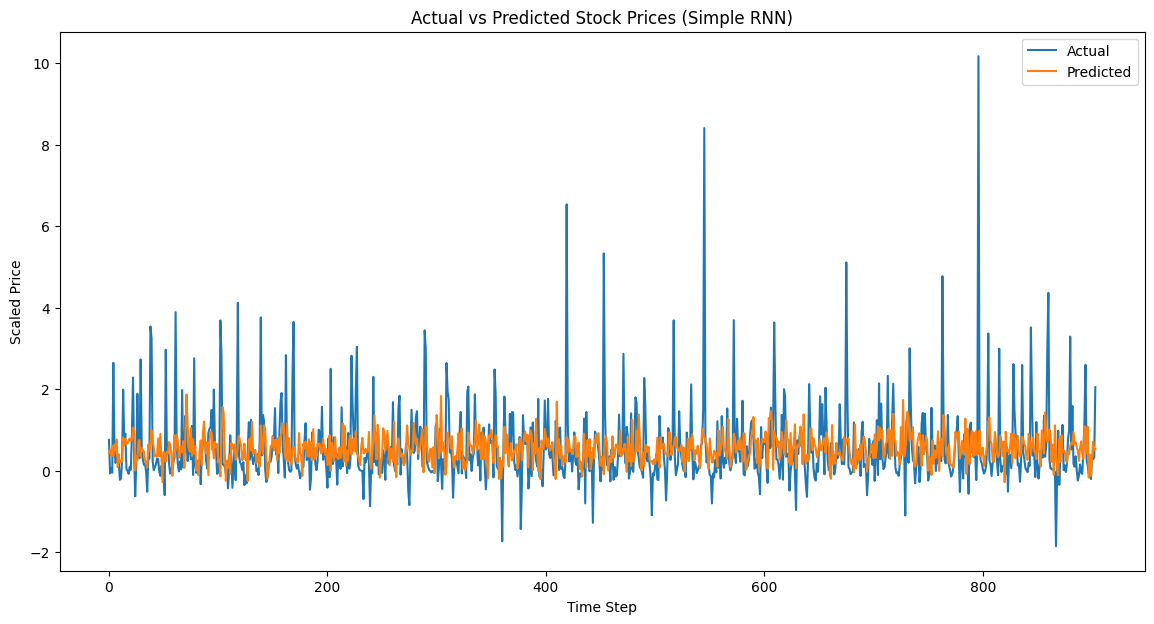

In [32]:
# Predict on the test data and plot
y_pred = optimal_simple_rnn_model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (Simple RNN)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [33]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error
from numpy import sqrt

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 0.9171
Root Mean Squared Error (RMSE): 0.9577


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [53]:
# # Define a function to create a model and specify default values for hyperparameters
def build_lstm_model(input_shape, units=50, activation='relu', num_layers=1):
    model = Sequential()
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Return sequences for all but the last LSTM layer
        if i == 0:
            model.add(LSTM(units=units, activation=activation, input_shape=input_shape, return_sequences=return_sequences))
        else:
            model.add(LSTM(units=units, activation=activation, return_sequences=return_sequences))
    model.add(Dense(1))  # Output layer for predicting a single value (closing price)
    model.compile(optimizer='adam', loss='mse')
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [54]:
# Find an optimal configuration
# Define the grid of hyperparameters to search
param_grid_lstm = {
    'units': [30, 50, 70],
    'epochs': [25, 50],
    'batch_size': [32, 64],
    'num_layers': [1, 2]
}

best_score_lstm = float('inf')
best_params_lstm = {}
best_model_lstm = None

# Iterate through the hyperparameter grid
for units in param_grid_lstm['units']:
    for epochs in param_grid_lstm['epochs']:
        for batch_size in param_grid_lstm['batch_size']:
            for num_layers in param_grid_lstm['num_layers']:
                print(f"Training with units={units}, epochs={epochs}, batch_size={batch_size}, num_layers={num_layers}")

                # Build the model
                model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                               units=units, activation='relu', num_layers=num_layers)

                # Train the model
                history = model.fit(
                    X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.3,  # Use a validation split during training
                    verbose=0  # Set verbose to 0 to reduce output during tuning
                )

                # Evaluate the model on the validation set
                loss = model.evaluate(X_test, y_test, verbose=0)
                mse = loss # For a single output and 'mse' loss, loss is the MSE

                print(f"  Validation MSE: {mse:.4f}")

                # Check if this is the best model so far
                if mse < best_score_lstm:
                    best_score_lstm = mse
                    best_params_lstm = {'units': units, 'epochs': epochs, 'batch_size': batch_size, 'num_layers': num_layers}
                    best_model_lstm = model # Store the best model

Training with units=30, epochs=25, batch_size=32, num_layers=1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Validation MSE: 0.9582
Training with units=30, epochs=25, batch_size=32, num_layers=2
  Validation MSE: 1.0160
Training with units=30, epochs=25, batch_size=64, num_layers=1
  Validation MSE: 0.9574
Training with units=30, epochs=25, batch_size=64, num_layers=2
  Validation MSE: 0.9448
Training with units=30, epochs=50, batch_size=32, num_layers=1
  Validation MSE: 1.0354
Training with units=30, epochs=50, batch_size=32, num_layers=2
  Validation MSE: 1.1273
Training with units=30, epochs=50, batch_size=64, num_layers=1
  Validation MSE: 1.0242
Training with units=30, epochs=50, batch_size=64, num_layers=2
  Validation MSE: 0.9934
Training with units=50, epochs=25, batch_size=32, num_layers=1
  Validation MSE: 1.0775
Training with units=50, epochs=25, batch_size=32, num_layers=2
  Validation MSE: 1.0360
Training with units=50, epochs=25, batch_size=64, num_layers=1
  Validation MSE: 1.1421
Training with units=50, epochs=25, batch_size=64, num_layers=2
  Validation MSE: 0.8761
Trainin

In [55]:
# Summarize results
print("\nBest Hyperparameters:")
print(best_params_lstm)
print(f"Best Validation MSE: {best_score_lstm:.4f}")


Best Hyperparameters:
{'units': 50, 'epochs': 25, 'batch_size': 64, 'num_layers': 2}
Best Validation MSE: 0.8761


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [56]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
optimal_lstm_model = build_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=best_params_lstm['units'],
    activation='relu',
    num_layers=best_params_lstm['num_layers']
)

history_lstm = optimal_lstm_model.fit(
    X_train, y_train,
    epochs=best_params_lstm['epochs'],
    batch_size=best_params_lstm['batch_size'],
    validation_split=0.3, # Use a validation split during training
    verbose=1
)

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 1.1803 - val_loss: 0.8578
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0089 - val_loss: 0.8448
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0640 - val_loss: 0.8443
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9693 - val_loss: 0.8445
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0912 - val_loss: 0.8420
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1556 - val_loss: 0.8464
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0127 - val_loss: 0.8452
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0341 - val_loss: 0.8513
Epoch 9/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1039 - val_loss: 0.8529
Epoch 10/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7291 - val_loss: 0.8693
Epoch 11/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9360 - val_loss: 0.8518
Epoch 12/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7815 - val_

In [57]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error
from numpy import sqrt

# Calculate MSE and RMSE
y_pred_lstm = optimal_lstm_model.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = sqrt(mse_lstm)

print(f"Mean Squared Error (MSE) for LSTM model: {mse_lstm:.4f}")
print(f"Root Mean Squared Error (RMSE) for LSTM model: {rmse_lstm:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean Squared Error (MSE) for LSTM model: 0.9872
Root Mean Squared Error (RMSE) for LSTM model: 0.9936


Plotting the actual vs predicted values

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


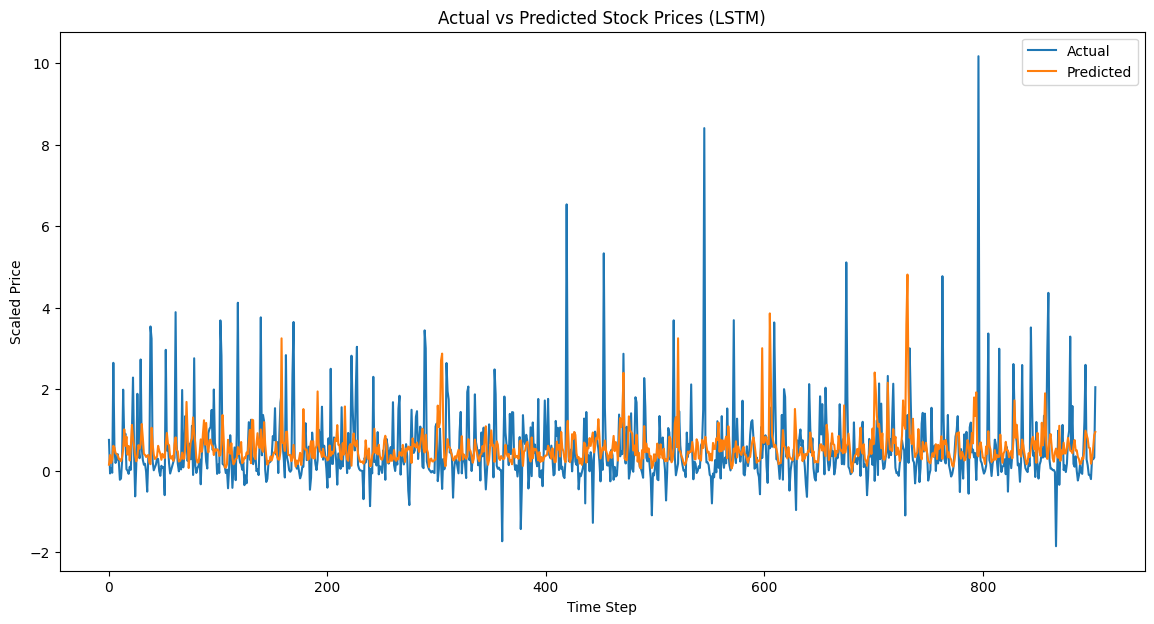

In [58]:
# Predict on the test data and plot
y_pred_lstm = optimal_lstm_model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [39]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [40]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [41]:
# Find an optimal configuration of simple RNN



In [42]:
# Find the best configuration



In [43]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [44]:
# Compute the performance of the model on the testing data set



In [45]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [46]:
# Find an optimal configuration of advanced RNN



In [47]:
# Find the best configuration



In [48]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [49]:
# Compute the performance of the model on the testing data set



In [50]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

**Data Loading and Preparation:**
- Data from the four companies IBM, Google, Amazon, and Microsoft was successfully loaded and combined into a single DataFrame.
- The joining of DataFrame is done on the basis of date column.
- Missing values were identified and handled by dropping the rows with missing data.
                
**Analysis and Visualization:**
- The frequency distribution of stock volumes showed varying patterns across the companies.
- The stock volume variation over time indicated fluctuations and trends specific to each company.
- The correlation matrix revealed high correlations between the 'Open', 'High', 'Low', and 'Close' prices for each individual stock, as expected.
- There were also varying levels of correlation between the prices of different stocks, suggesting that they are influenced by similar market factors. Volume, on the other hand, showed weaker correlations with the price features.
- IBM has significantly lower correlation with other companies.
                             
**Data Processing for RNNs:**
- A `create_windowed_data()` function was implemented to create sequences of data (windows) for training the RNN models. A window size of 5 and a stride of 1 were used.
- A `scale_windowed_data()` function was used to scale the data within each window using `MinMaxScaler` to prevent data leakage.
- The `prepare_rnn_data()` function combined these steps and split the data into training and testing sets (70% train, 30% test).
                             
**RNN Models and Hyperparameter Tuning:**
- Both a Simple RNN and an LSTM model were built and tuned using a grid search over different hyperparameters (units, epochs, batch size, and number of layers).
- The best hyperparameters for the Simple RNN model were {'units': 30, 'epochs': 25, 'batch_size': 64, 'num_layers': 1}, resulting in a validation MSE of 0.9121.
- The best hyperparameters for the LSTM model were {'units': 50, 'epochs': 25, 'batch_size': 64, 'num_layers': 2}, resulting in a validation MSE of 0.8761.

**Model Performance:**
- The Simple RNN model achieved a Mean Squared Error (MSE) of 0.9171 and a Root Mean Squared Error (RMSE) of 0.9577 on the test data.
- The LSTM model achieved a Mean Squared Error (MSE) of 0.9872 and a Root Mean Squared Error (RMSE) of 0.9936 on the test data.

Based on the validation MSE during hyperparameter tuning, the LSTM model with 2 layers and 50 units performed slightly better than the Simple RNN model. However, the final evaluation on the test set showed a slightly higher MSE for the LSTM model in this particular run. It's important to note that due to the stochastic nature of neural network training, results can vary between runs.

**Further Improvements:**
- **Different Window Sizes and Strides:** Experiment with different window sizes and strides to capture longer or shorter-term dependencies in the data.
- **Larger Hyperparameter Search Space:** Expand the range of hyperparameters and use more sophisticated tuning techniques (e.g., random search, Bayesian optimization).
- **Cross-Validation:** Implement time series cross-validation to get a more robust estimate of model performance.
- **Predicting Other Metrics:** Instead of just the closing price, the models could be extended to predict other metrics like the next day's opening price, high, low, or volume.
